In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import OneHotEncoder, LabelEncoder 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from bayes_opt import BayesianOptimization

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, f1_score

import time
import warnings
warnings.filterwarnings("ignore")

# Problem Statement

Supervised: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features

Classification: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)

Performance Metric: ROC AUC

Data: The data is provided by Home Credit, a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. dataset: https://www.kaggle.com/c/home-credit-default-risk/overview

**Inspired by**
- https://www.kaggle.com/code/ashishpatel26/kfold-lightgbm
- https://www.kaggle.com/code/sz8416/simple-bayesian-optimization-for-lightgbm/notebook

# Import Data

In [78]:
# import data files
train = pd.read_csv('application_train.csv')
print('train: ', train.shape)

test = pd.read_csv('application_test.csv')
print('test: ', test.shape)

previous_application = pd.read_csv('previous_application.csv')
print('previous_application: ', previous_application.shape)

bureau_balance = pd.read_csv('bureau_balance.csv')
print('bureau_balance: ', bureau_balance.shape)

bureau = pd.read_csv('bureau.csv')
print('bureau: ', bureau.shape)

credit_card_balance = pd.read_csv('credit_card_balance.csv')
print('credit_card_balance: ', credit_card_balance.shape)

POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv')
print('POS_CASH_balance: ', POS_CASH_balance.shape)

installments_payments = pd.read_csv('installments_payments.csv')
print('installments_payments: ', installments_payments.shape)

train:  (307511, 122)
test:  (48744, 121)
previous_application:  (1670214, 37)
bureau_balance:  (27299925, 3)
bureau:  (1716428, 17)
credit_card_balance:  (3840312, 23)
POS_CASH_balance:  (10001358, 8)
installments_payments:  (13605401, 8)


# EDA

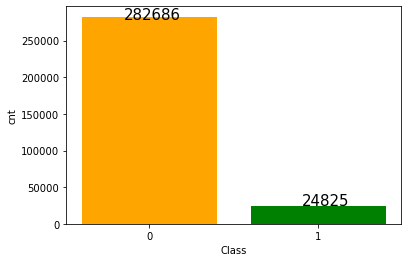

In [26]:
v1 = train['TARGET'].value_counts()
x = np.arange(len(v1))
y = v1.values
plt.bar(np.arange(len(v1)), y, color=['orange', 'green'])
plt.xticks(x, [0,1])
plt.xlabel('Class')
plt.ylabel('cnt')
#plt.ylim(0, 100000)
plt.text(-0.15, 280000, s="282686", fontsize=15)
plt.text(0.9, 25000, s="24825", fontsize=15)
plt.show()

In [58]:
# Check for missing data, just show the first 20 features
cols_with_missing = [col for col in train.columns if train[col].isnull().any()]
miss_count = train.isna().sum()
pd.DataFrame(round(miss_count.div(len(train))[cols_with_missing].head(20), 2), 
             columns=['missing vlaue pct'])

,missing vlaue pct
AMT_ANNUITY,0.00
AMT_GOODS_PRICE,0.00
NAME_TYPE_SUITE,0.00
OWN_CAR_AGE,0.66
OCCUPATION_TYPE,0.31
CNT_FAM_MEMBERS,0.00
EXT_SOURCE_1,0.56
EXT_SOURCE_2,0.00
EXT_SOURCE_3,0.20
APARTMENTS_AVG,0.51


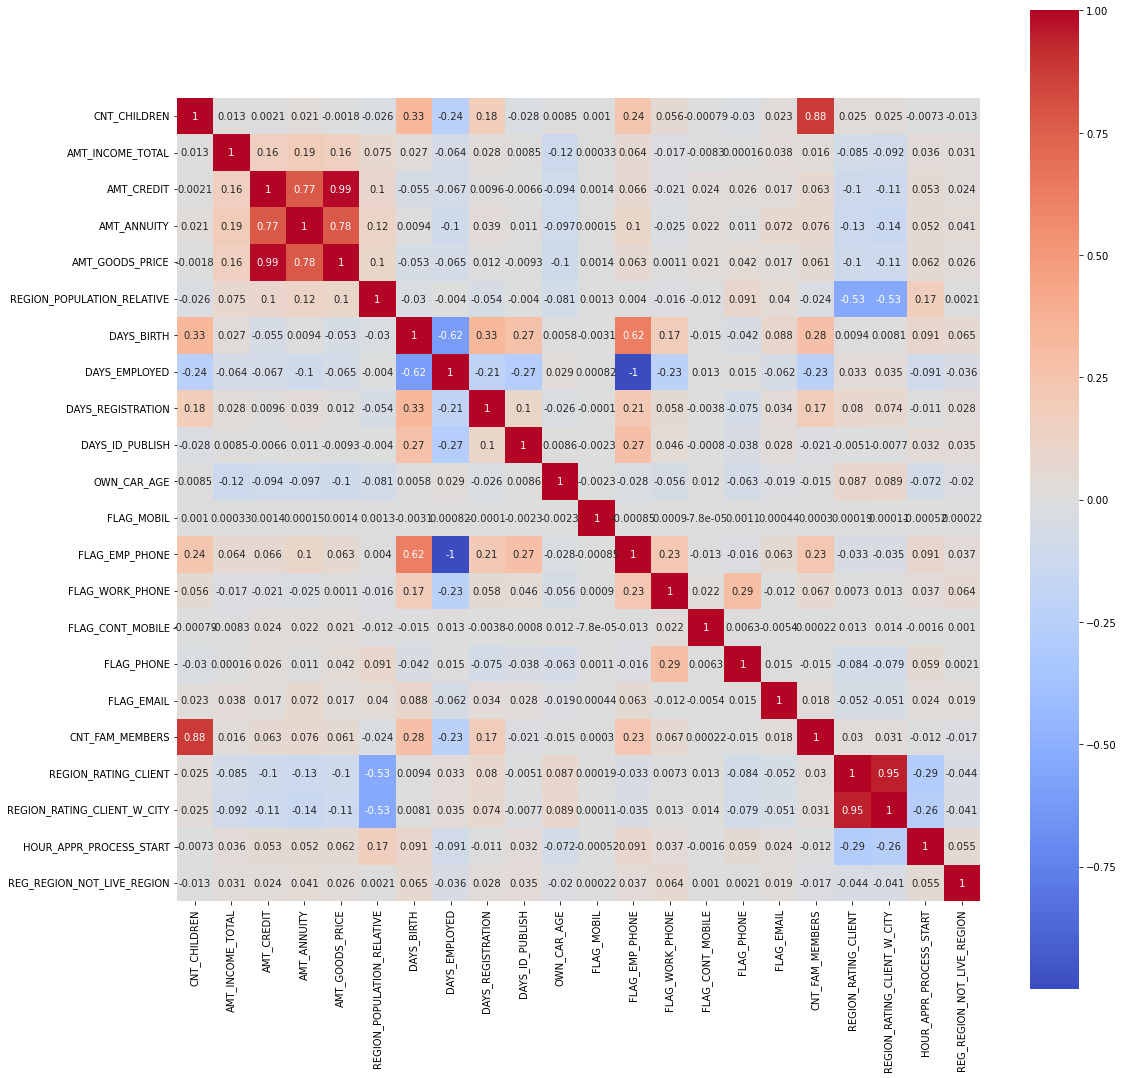

In [36]:
# correlation
featureMeans = list(train.columns[6:35])
plt.figure(figsize=(18,18))
sns.heatmap(train[featureMeans].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

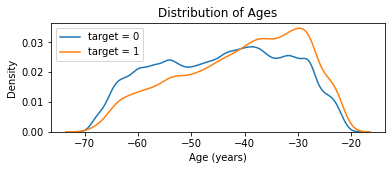

In [38]:
plt.figure(figsize = (6, 2))

# KDE plot of loans that were repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target = 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target = 1')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.legend()
plt.show()

# The target == 1 curve skews towards the younger end of the range.

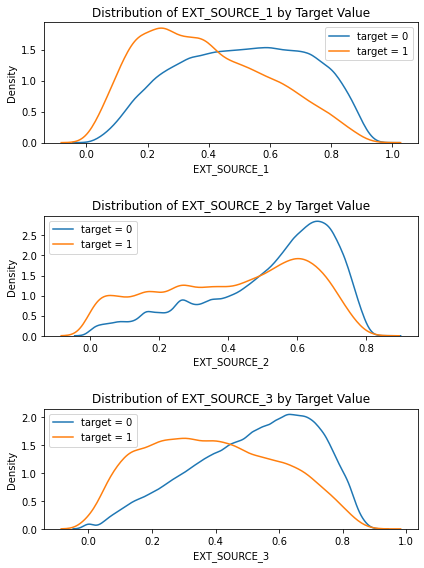

In [28]:
plt.figure(figsize = (6, 8))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target = 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target = 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

<AxesSubplot:xlabel='NAME_CONTRACT_TYPE', ylabel='AMT_CREDIT'>

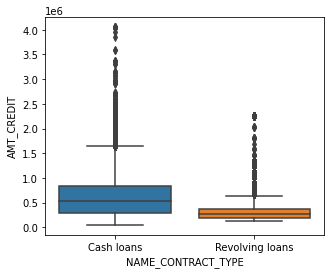

In [67]:
plt.figure(figsize=(5,4))
sns.boxplot(x='NAME_CONTRACT_TYPE', y='AMT_CREDIT', data=train)

<AxesSubplot:xlabel='NAME_INCOME_TYPE', ylabel='AMT_CREDIT'>

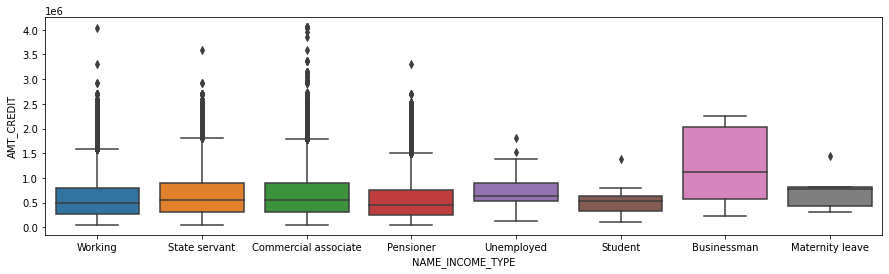

In [66]:
plt.figure(figsize=(15,4))
sns.boxplot(x='NAME_INCOME_TYPE', y='AMT_CREDIT', data=train)

<AxesSubplot:xlabel='NAME_INCOME_TYPE', ylabel='AMT_INCOME_TOTAL'>

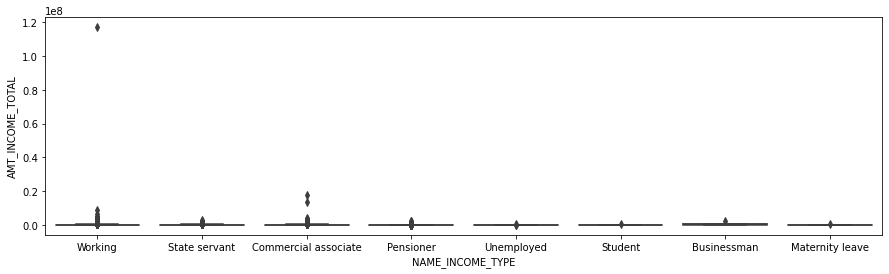

In [74]:
plt.figure(figsize=(15,4))
sns.boxplot(x='NAME_INCOME_TYPE', y='AMT_INCOME_TOTAL', data=train)

# Data Cleaning & Feature Engineering

In [79]:
def one_hot_encoder(df):
    
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    
    ohe = OneHotEncoder(handle_unknown='ignore')
    cat_ohe = ohe.fit_transform(df[categorical_columns]).toarray()
    
    # concat the numerical columns and tranformed catrgorical columns
    df_new = df.drop(categorical_columns, axis=1)
    df_new2 = pd.DataFrame(cat_ohe, columns=ohe.get_feature_names_out())
    df_all = pd.concat([df_new, df_new2], axis=1)
    new_columns = [c for c in df_all.columns if c not in original_columns]
    
    return df_all, new_columns 

In [80]:
def application_preprocessing(train, test):
    
    # create useful features
    train['CREDIT_INCOME_PERCENT'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
    train['ANNUITY_INCOME_PERCENT'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
    train['CREDIT_TERM'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
    train['DAYS_EMPLOYED_PERCENT'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']

    test['CREDIT_INCOME_PERCENT'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
    test['ANNUITY_INCOME_PERCENT'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
    test['CREDIT_TERM'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
    test['DAYS_EMPLOYED_PERCENT'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
    
    # choose some of the important features to create polynomial features
    poly_features = train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
    poly_features_test = test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

    # imputer for handling missing values
    imputer = SimpleImputer(strategy = 'median')
    poly_features = imputer.fit_transform(poly_features)
    poly_features_test = imputer.transform(poly_features_test)
    
    # create Polynomial Features
    poly_transformer = PolynomialFeatures(degree = 3)
    poly_features = poly_transformer.fit_transform(poly_features)
    poly_features_test = poly_transformer.transform(poly_features_test)

    # Create a dataframe of the features 
    poly_features = pd.DataFrame(poly_features, columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
    poly_features_test = pd.DataFrame(poly_features_test, columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

    # Merge polynomial features into training/testing dataframe
    poly_features['SK_ID_CURR'] = train['SK_ID_CURR']
    train_poly = train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

    poly_features_test['SK_ID_CURR'] = test['SK_ID_CURR']
    test_poly = test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

    # Print out the new shapes
    print('Training data with polynomial features shape: ', train_poly.shape)
    print('Testing data with polynomial features shape:  ', test_poly.shape)

    X_train = train_poly.drop('TARGET', axis=1)
    y_train = train_poly['TARGET']
    X_test = test_poly.copy()

    categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']
    
    class_dict = {}
    for i in categorical_columns:
        le = LabelEncoder()
        X_train[i] = le.fit_transform(X_train[i])
        class_dict[i] = list(le.classes_)
        X_test[i] = le.transform(X_test[i])
        

    return train_poly, test_poly

In [81]:
def previous_application_preprocessing(df):
    
    df, cat_cols = one_hot_encoder(df)
    df['DAYS_FIRST_DRAWING'].max()
    df['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    df['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    df['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    df['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    df['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    df['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    df['APP_CREDIT_PERC'] = df['AMT_CREDIT']/df['AMT_APPLICATION'] 

    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': [ 'max','mean'],
        'AMT_CREDIT': [ 'max', 'mean'],
        'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
        'AMT_GOODS_PRICE': [ 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
        'DAYS_DECISION': [ 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
        
    df_agg = df.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    df_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df_agg.columns.tolist()])
    
    # Previous Applications: Approved Applications - only numerical features
    approved = df[df['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    df_agg = df_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Previous Applications: Refused Applications - only numerical features
    refused = df[df['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    df_agg = df_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    
    return df_agg

In [82]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance_preprocessing(bureau_balance, bureau):

    bb, bb_cat = one_hot_encoder(bureau_balance)
    bureau, bureau_cat = one_hot_encoder(bureau)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    
    return bureau_agg

In [83]:
def credit_card_balance_preprocessing(cc):
    
    cc, cat_cols = one_hot_encoder(cc)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    return cc_agg

In [84]:
def pos_cash_preprocessing(pos):
   
    pos, cat_cols = one_hot_encoder(pos)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

    return pos_agg

In [85]:
def installments_payments_preprocessing(ins):
    
    ins, cat_cols = one_hot_encoder(ins)
    
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum','min','std' ],
        'DBD': ['max', 'mean', 'sum','min','std'],
        'PAYMENT_PERC': [ 'max','mean', 'var','min','std'],
        'PAYMENT_DIFF': [ 'max','mean', 'var','min','std'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum','min','std'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum','std'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum','std']
    }
    
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    return ins_agg

In [86]:
# data preprocessing for every dataset
train, test = application_preprocessing(train, test)
previous_application = previous_application_preprocessing(previous_application)
bureau_and_balance = bureau_and_balance_preprocessing(bureau_balance, bureau)
credit_card_balance = credit_card_balance_preprocessing(credit_card_balance)
pos_cash = pos_cash_preprocessing(POS_CASH_balance)
installments_payments = installments_payments_preprocessing(installments_payments)

Training data with polynomial features shape:  (307511, 161)
Testing data with polynomial features shape:   (48744, 160)


In [87]:
## merge dataset using ID
df_train = train.join(bureau_and_balance, how='left', on='SK_ID_CURR')
df_train = df_train.join(previous_application, how='left', on='SK_ID_CURR')
df_train = df_train.join(pos_cash, how='left', on='SK_ID_CURR')
df_train = df_train.join(installments_payments, how='left', on='SK_ID_CURR')
df_train = df_train.join(credit_card_balance, how='left', on='SK_ID_CURR')

df_test = test.join(bureau_and_balance, how='left', on='SK_ID_CURR')
df_test = df_test.join(previous_application, how='left', on='SK_ID_CURR')
df_test = df_test.join(pos_cash, how='left', on='SK_ID_CURR')
df_test = df_test.join(installments_payments, how='left', on='SK_ID_CURR')
df_test = df_test.join(credit_card_balance, how='left', on='SK_ID_CURR')

# Train and Test dataset

In [185]:
X_train = df_train.drop('TARGET', axis=1)
y_train = df_train['TARGET']

X_test = df_test.copy()

In [186]:
import re
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Logistic Reression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train_scaled[numerical_cols], y_train)
log_reg_pred = log_reg.predict_proba(X_test_scaled[numerical_cols])[:, 1]

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['TARGET'] = log_reg_pred
submission.to_csv('submission_log_reg.csv', index=False)
submission.head()

# LightGBM Model

In [204]:
def lightGBM_Bayesian_model(X_train, y_train, X_test, feature):
    X_train = X_train[feature]
    X_test = X_test[feature]
    
    features=[x for x in X_train.columns]
    #categorical_cols = [c for c in X_train.columns if (1 < X_train[c].nunique()) & (X_train[c].dtype != np.number) & (X_train[c].dtype != int)]
    categorical_cols = [col for col in train.columns if train[col].dtype == 'object']
    
    # create lgb dataset
    train_data = lgb.Dataset(X_train, label=y_train, feature_name=features, categorical_feature=categorical_cols, free_raw_data=False)
    test_data = lgb.Dataset(X_test, reference=train_data, feature_name=features, categorical_feature=categorical_cols, free_raw_data=False)

    # model
    def lgb_func(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, subsample, 
                 min_split_gain, min_child_weight, learning_rate):
        
        params = {'application':'binary', 'metric':'auc', 'early_stopping_round': 200, 'verbose':-1}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['learning_rate'] = learning_rate
        cv_result = lgb.cv(params, train_data, nfold=5, seed=42, stratified=True, verbose_eval =200, metrics=['auc'])

        return max(cv_result['auc-mean'])

    # BayesianOptimization
    lgbBO = BayesianOptimization(lgb_func, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'subsample': (0.7, 1),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50),
                                            'learning_rate': (0.001, 0.05)}, random_state=0)
    init_round=3
    opt_round=10
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    print('AUC: ', lgbBO.max['target'])
    print('parameters: ', lgbBO.max['params'])
    
    # best parameters
    max_params = lgbBO.max['params']
    max_params['num_leaves'] = int(round(max_params['num_leaves']))
    max_params['max_depth'] = int(round(max_params['max_depth']))

    # train the model using best parameters
    model = lgb.train(max_params, train_data, feature_name=features, 
                      categorical_feature=categorical_cols)
    
    # feature importance
    feature_imp = []
    feature_imp = model.feature_importance(importance_type="gain")
    feature_importance = pd.DataFrame({'features':X_train.columns, 'gain':feature_imp})
    
    # predict
    y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
    print('AUC:', metrics.roc_auc_score(np.array(y_train), y_pred_train))
    y_pred_test = model.predict(X_test)
    
    max_ = lgbBO.max
    
    return max_, feature_importance, y_pred_test

In [205]:
%%time
feature = X_train.columns
lgb_1 = lightGBM_Bayesian_model(X_train, y_train, X_test, feature)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7641   |  0.9098   |  0.6722   |  3.014    |  1.635    |  0.02176  |  7.577    |  24.69    |  0.08929  |  44.24    |  0.815    |
|  2        |  0.7438   |  0.9583   |  0.5231   |  2.84     |  2.777    |  0.004481 |  5.348    |  5.91     |  0.08343  |  40.34    |  0.961    |
|  3        |  0.7454   |  0.9957   |  0.7393   |  2.307    |  2.342    |  0.006795 |  7.553    |  11.45    |  0.09452  |  34.96    |  0.8244   |
|  4        |  0.7702   |  0.8642   |  0.6763   |  3.375    |  1.109    |  0.03031  |  8.088    |  33.86    |  0.0868   |  45.0     |  0.7764   |
|  5        |  0.766    |  0.9797   |  0.5008   |  4.151    |  0.5648   |  0.02242  |  7.293    |  33.25    |  0.04076  |  4

In [206]:
lgb_1[0]

{'target': 0.7783516563533796,
 'params': {'bagging_fraction': 0.8,
  'feature_fraction': 0.9,
  'lambda_l1': 0.0,
  'lambda_l2': 3.0,
  'learning_rate': 0.05,
  'max_depth': 8.99,
  'min_child_weight': 39.99611572837116,
  'min_split_gain': 0.1,
  'num_leaves': 45.0,
  'subsample': 0.7}}

<BarContainer object of 15 artists>

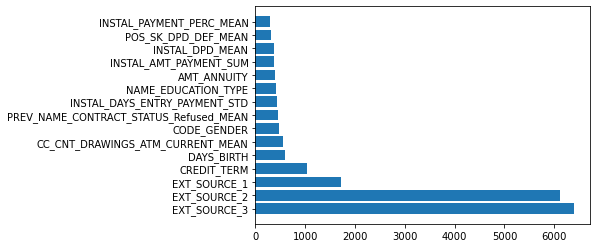

In [207]:
# feature importance
data = lgb_1[1].sort_values('gain', ascending=False).head(15)
plt.barh('features','gain',data=data)

In [171]:
features_selected = data['features'].tolist()[0:30]

In [166]:
%%time
lgb_2 = lightGBM_Bayesian_model(X_train, y_train, X_test, feature=features_selected)

/var/folders/jw/71kz1mm55lj8zynw1gmlz4_m0000gn/T/ipykernel_1334/375244103.py:6: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  categorical_cols = [c for c in X_train.columns if (1 < X_train[c].nunique()) & (X_train[c].dtype != np.number) & (X_train[c].dtype != int)]


|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_sp... | num_it... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  1        |  0.7581   |  0.9098   |  0.6722   |  3.014    |  1.635    |  0.02176  |  7.577    |  24.69    |  0.08929  |  196.4    |  32.05    |  0.9375   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  2        |  0.7398   |  0.9058   |  0.5544   |  4.628    |  0.2131   |  0.005269 |  5.081    |  42.47    |  0.07804  |  187.0    |  44.55    |  0.9397   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  3        |  0.7445   |  0.8923   |  0.7244   |  0.5914   |  1.92     |  0.008024 |  8.769    |  28.48    |  0.04205  |  126.5    |  40.26    |  0.8368   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  4        |  0.7606   |  0.9356   |  0.3657   |  2.099    |  2.069    |  0.03667  |  7.675    |  25.4     |  0.08456  |  196.0    |  31.03    |  0.9453   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  5        |  0.7571   |  1.0      |  0.1      |  0.0      |  3.0      |  0.05     |  8.697    |  25.78    |  0.02448  |  191.9    |  24.0     |  0.9875   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[200]	cv_agg's auc: 0.75581 + 0.00441405
|  6        |  0.7558   |  1.0      |  0.1      |  0.0      |  3.0      |  0.05     |  6.496    |  31.98    |  0.07351  |  200.0    |  27.32    |  0.9138   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  7        |  0.7542   |  1.0      |  0.1      |  0.0      |  3.0      |  0.05     |  5.0      |  28.14    |  0.09701  |  189.4    |  32.19    |  0.7      |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  8        |  0.7562   |  0.9552   |  0.7566   |  1.749    |  2.604    |  0.02164  |  5.561    |  21.26    |  0.0148   |  199.2    |  25.25    |  0.9413   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  9        |  0.7538   |  0.9336   |  0.384    |  1.214    |  2.73     |  0.0179   |  8.953    |  14.76    |  0.06066  |  190.6    |  29.15    |  0.9356   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  10       |  0.7463   |  0.923    |  0.387    |  4.669    |  0.7584   |  0.009664 |  8.672    |  27.46    |  0.0596   |  194.7    |  26.94    |  0.9818   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  11       |  0.7616   |  0.9657   |  0.3927   |  0.2376   |  3.0      |  0.04835  |  6.619    |  23.75    |  0.06912  |  197.1    |  29.89    |  0.9341   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  12       |  0.7627   |  0.9964   |  0.7703   |  0.2841   |  0.6478   |  0.0436   |  6.964    |  27.04    |  0.07821  |  199.4    |  31.66    |  0.8708   |


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


|  13       |  0.7596   |  0.9009   |  0.243    |  1.088    |  2.962    |  0.03371  |  6.735    |  27.98    |  0.09226  |  198.0    |  35.71    |  0.8515   |
AUC:  0.7626855012917296
parameters:  {'bagging_fraction': 0.9964251837379999, 'feature_fraction': 0.7702854394709041, 'lambda_l1': 0.2840685470795229, 'lambda_l2': 0.6478171391985383, 'learning_rate': 0.04360273878104589, 'max_depth': 6.96396049093446, 'min_child_weight': 27.04190694640546, 'min_split_gain': 0.0782100384290074, 'num_iterations': 199.362537277476, 'num_leaves': 31.658735044338858, 'subsample': 0.8707808504633531}
[LightGBM] [Warning] bagging_fraction is set=0.9964251837379999, subsample=0.8707808504633531 will be ignored. Current value: bagging_fraction=0.9964251837379999
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


AUC: 0.7774055483251272
CPU times: user 14min 12s, sys: 12.8 s, total: 14min 25s
Wall time: 4min 2s


In [168]:
lgb_2[0]

{'target': 0.7626855012917296,
 'params': {'bagging_fraction': 0.9964251837379999,
  'feature_fraction': 0.7702854394709041,
  'lambda_l1': 0.2840685470795229,
  'lambda_l2': 0.6478171391985383,
  'learning_rate': 0.04360273878104589,
  'max_depth': 6.96396049093446,
  'min_child_weight': 27.04190694640546,
  'min_split_gain': 0.0782100384290074,
  'num_iterations': 199.362537277476,
  'num_leaves': 31.658735044338858,
  'subsample': 0.8707808504633531}}

In [208]:
submission = pd.read_csv('sample_submission.csv')
submission['TARGET'] = lgb_1[2]
submission['TARGET'] = submission['TARGET'].apply(lambda x: 0 if x <0 else x)
submission.to_csv('submission_lightGBM_Baysian.csv', index=False)
submission.head()

,SK_ID_CURR,TARGET
0,100001,0.068597
1,100005,0.129874
2,100013,0.021104
3,100028,0.038031
4,100038,0.129250
